In [1]:
import pandas as pd #一个数据处理和分析库，常用于处理结构化数据（如表格数据）。
import numpy as np #一个用于科学计算的库，提供了高效的数组处理和数学运算功能。
import matplotlib.pyplot as plt #一个常用的绘图库，能够生成各种静态、动态和交互式的图形。
from sklearn.preprocessing import StandardScaler #用于标准化特征，即将特征缩放到均值为0、标准差为1的范围。可以提高算法的性能。
import re #Python 内置的正则表达式库，用于处理字符串的模式匹配、替换、分割等操作。

In [2]:
# 1. 加载数据
df = pd.read_csv('data.csv')
#用 pandas 库中的 read_csv() 函数读取一个名为 'data.csv' 的 CSV 文件，并将其加载为一个 DataFrame 对象，赋值给变量 df。
#DataFrame 是一个二维的、带有标签的数据结构，可以看作是一个表格，包含行和列

In [3]:
# 2. 提取特征
#定义了一个名为 extract_features 的函数，从给定的 URL 中提取一些特征信息
def extract_features(url):
    
    length = len(url) #提取域名长度
    contains_digit = int(bool(re.search(r'\d', url)))  # 检查域名是否包含数字
    special_chars = len(re.findall(r'[-_?&=]', url)) # 检查特殊字符的数量
    
    # 提取域名的数量
    # 更新正则表达式，支持带有和不带有协议部分的 URL
    domain = re.search(r'https?://([^/]+)|([^/]+)', url)  # 匹配 http(s):// 或者直接匹配域名部分
    domain_count = 0
    
    if domain:
        # 如果有匹配到域名
        # 对于匹配 http(s):// 域名的情况，获取第一个分组（第一个括号），否则获取第二个分组
        domain_name = domain.group(1) if domain.group(1) else domain.group(2)
        # 拆分域名并计算域名部分的数量
        domain_parts = domain_name.split('.')
        if len(domain_parts) >= 2:
            domain_count = len(domain_parts)  # 域名部分的数量（包括顶级域名和子域名）
    
    return [length, contains_digit, special_chars, domain_count]

In [4]:
# 提取每个 URL 的特征
features = df['url'].apply(extract_features)

# 将提取的特征转换为 DataFrame
feature_df = pd.DataFrame(features.tolist(), columns=["Length", "Contains Digit", "Special Chars", "Domain Count"])

# 将标签列与特征合并
df = pd.concat([df, feature_df], axis=1)

# 查看输出前几行
print(df.head())

                                                 url label  Length  \
0      greekchat.com/gcforums/showthread.php?t=61440  good      45   
1  thomasnet.com/products/software-electronic-com...  good      67   
2  classmates.com/directory/public/memberprofile/...  good      71   
3                       zapchast43.ru/zapoy/gate.php   bad      28   
4                          49thvirginiainfantry.com/  good      25   

   Contains Digit  Special Chars  Domain Count  
0               1              2             2  
1               1              4             2  
2               1              2             2  
3               1              0             2  
4               1              0             2  


In [5]:
# 提取每个URL的特征
features = np.array([extract_features(url) for url in df['url']])
print(features)

[[45  1  2  2]
 [67  1  4  2]
 [71  1  2  2]
 ...
 [38  0  0  3]
 [17  0  0  2]
 [36  0  1  3]]


In [6]:
# 将标签转为数值类型 (0 = bad, 1 = good)，并存储为NumPy数组。
labels = np.array([1 if label == 'good' else 0 for label in df['label']])

In [7]:
# 3. 实现数据集划分，前70%为训练集，后30%为测试集
def train_test(X, y, test_size=0.3, random_state=None):
    # 设置随机种子，保证每次划分的可重复性，后续可进行评估
    if random_state is not None:
        np.random.seed(random_state)
    
    # 获取数据的总长度
    total_samples = len(X)
    
    # 计算测试集大小，确保其为整数。
    test_samples = int(total_samples * test_size)
    
    # 生成一个随机排列的索引
    indices = np.random.permutation(total_samples)
    
    # 划分训练集和测试集的索引
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]
    
    # 使用索引从数据中选择训练集和测试集
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [8]:
#将 features（特征数据）和 labels（标签数据）按照指定的比例划分为训练集和测试集，并设置随机种子以保证划分的可重复性
X_train, X_test, y_train, y_test = train_test(features, labels, test_size=0.3, random_state=42)

In [9]:
# 4. 数据标准化（有助于提升模型性能）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#每个特征都被标准化到了均值为 0，标准差为 1 的范围。

In [10]:
#定义Sigmoid 函数计算
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

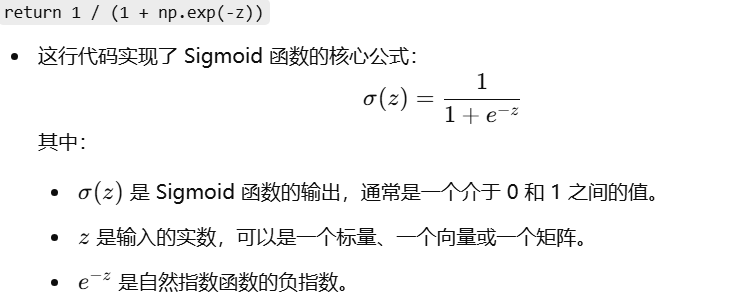

In [11]:
#定义代价函数
def compute_cost(X, y, theta):
    m = len(y)  # 样本数量
    h = sigmoid(X.dot(theta))  # 预测值，使用 Sigmoid 函数计算
    # 代价函数公式
    cost = (-1 / m) * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
    return cost

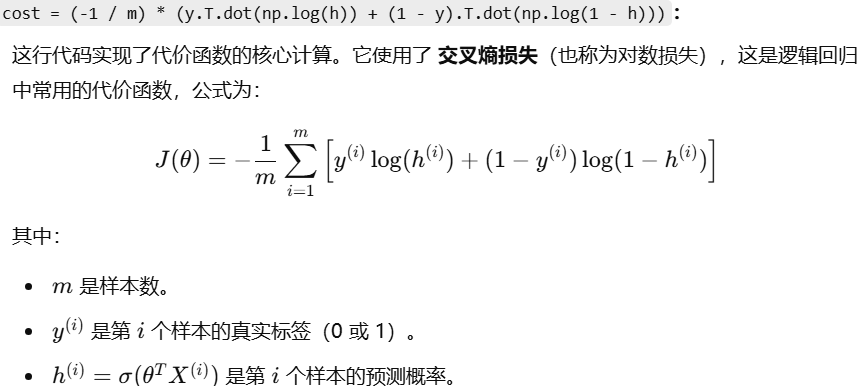

In [12]:
# 梯度下降算法
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = np.zeros(iterations) # 存储每次迭代的代价函数值
    for i in range(iterations):
        h = 1 / (1 + np.exp(-X.dot(theta)))  # 引入Sigmoid 函数，计算预测值
        theta = theta - (alpha / m) * X.T.dot(h - y)  # 梯度更新
        cost_history[i] = compute_cost(X, y, theta)  # 保存每次迭代的代价函数

        # 每50次迭代输出一次代价函数值
        if i % 50 == 0:
            print(f"Iteration {i} | Cost: {cost_history[i]}")
            
    return theta, cost_history # 返回优化后的参数和代价函数历史

In [13]:
# 训练模型：封装训练过程
def train_model(X, y, learning_rate, iterations):
    # 添加偏置项到特征矩阵
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]  # 在特征矩阵前添加一列1，用于偏置项
    theta_initial = np.zeros(X_bias.shape[1])  # 初始化theta为0
    
    # 调用梯度下降
    theta_optimal, cost_history = gradient_descent(X_bias, y, theta_initial, learning_rate, iterations)
    
    return theta_optimal, cost_history #返回最优参数值，代价函数在每次迭代中的值，可以用来观察模型的收敛情况。

In [14]:
# 预测函数
def predict(X, theta):
    # 计算预测值
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]  # 添加偏置项
    h = 1 / (1 + np.exp(-X_bias.dot(theta)))  # Sigmoid 函数
    return (h >= 0.5).astype(int)  # 返回0或1作为预测结果

In [15]:
# 10. 计算准确率
def accuracy_score(y_true, y_pred):
    # 确保输入是 NumPy 数组 
    y_true = np.array(y_true) #实际标签 y_true
    y_pred = np.array(y_pred) #预测标签 y_pred
    
    # 计算正确预测的样本数
    correct_predictions = np.sum(y_true == y_pred) 
    
    # 计算准确率
    accuracy = correct_predictions / len(y_true)
    return accuracy

In [16]:
# 训练模型
alpha = 0.1 #设置学习率
iterations = 1000 #设置迭代次数
theta_optimal, cost_history = train_model(X_train, y_train, alpha, iterations)

Iteration 0 | Cost: 0.6826376194905125
Iteration 50 | Cost: 0.48566833003919335
Iteration 100 | Cost: 0.45687372501593687
Iteration 150 | Cost: 0.4484972942026448
Iteration 200 | Cost: 0.44450730690311097
Iteration 250 | Cost: 0.4419954412628632
Iteration 300 | Cost: 0.4402036827324742
Iteration 350 | Cost: 0.4388559399763458
Iteration 400 | Cost: 0.43781658840973137
Iteration 450 | Cost: 0.4370037887530647
Iteration 500 | Cost: 0.43636223489876785
Iteration 550 | Cost: 0.43585231723965573
Iteration 600 | Cost: 0.43544475585817366
Iteration 650 | Cost: 0.4351174791355258
Iteration 700 | Cost: 0.43485361950777407
Iteration 750 | Cost: 0.43464014989777255
Iteration 800 | Cost: 0.43446692254009095
Iteration 850 | Cost: 0.43432597510737203
Iteration 900 | Cost: 0.4342110209252807
Iteration 950 | Cost: 0.4341170691972725


In [17]:
# 打印最终的theta值
print("Optimized theta values:", theta_optimal)

Optimized theta values: [ 1.63309123 -0.88473273 -0.18534651  1.11058123 -0.20939068]


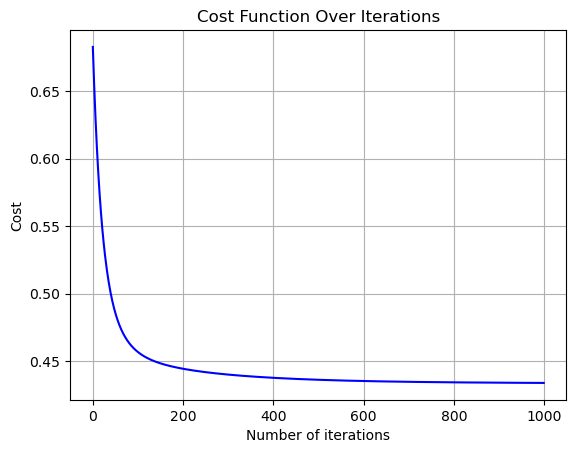

In [18]:
# 绘制代价函数变化图像
plt.plot(np.arange(iterations), cost_history, color='blue')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost Function Over Iterations')
plt.grid(True)
plt.show()

In [19]:
# 使用训练好的模型对测试集进行预测
y_pred = predict(X_test, theta_optimal)

In [20]:
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 82.56%


In [21]:
def predict_single_url(url, theta_optimal, scaler):
    # 提取单个 URL 的特征
    features = np.array(extract_features(url)).reshape(1, -1)
    
    # 使用训练集相同的标准化器进行标准化
    features_scaled = scaler.transform(features)
    
    # 使用训练好的模型进行预测
    prediction = predict(features_scaled, theta_optimal)
    
    # 输出预测结果
    if prediction == 1:
        print(f"URL '{url}' 是正常的。")
    else:
        print(f"URL '{url}' 是恶意的。")

# 输入 URL 进行判断
url_to_check = input("请输入 URL 以判断是否为恶意 URL: ")
predict_single_url(url_to_check, theta_optimal, scaler)


请输入 URL 以判断是否为恶意 URL:  aaaaaaaaaa


URL 'aaaaaaaaaa' 是正常的。
